### Shi Tomashi exractor and BRIEF descriptor

In [2]:
import cv2
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from tqdm import tqdm

PYTHON_PATHS = ['../', '/home/alena/repos/ros-bag-processing']
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from ros_bag_processing.enlighting.gamma import GammaModel
import utils

!pip uninstall -y onnxruntime-gpu
!pip install onnxruntime

try:
    from enlighten_inference import EnlightenOnnxModel as EnlightenGanModel
except:
    print("Error")
    sys.exit()
import onnxruntime as rt
rt.get_device()

from matching.fundamental_matrix import plot_good_matches, find_good_matches

In [3]:
def ShiTomashi(raw_img):
    
    # parameters for lucas kanade optical flow
    winSize = (9,9)
    maxLevel = 2
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)

    # parameters for ShiTomasi corner detection
    maxCorners, qualityLevel, minDistance, blockSize = [30, 0.3, 7, 7]
    
    gray = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, maxCorners, qualityLevel, minDistance, blockSize)
    try:
        corners = np.int0(corners)
        kp = cv2.KeyPoint_convert(corners)
        return kp, cv2.drawKeypoints(raw_img, kp, None)
    except:
        return [], raw_img

In [4]:
def describeBRIEF(img, kp):
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    _, des = brief.compute(img, kp)
    return des, cv2.drawKeypoints(img, kp, None)

In [5]:
def calculate(img):
    kp, img_kp = ShiTomashi(img)
    ds, img_kp2 = describeBRIEF(img, kp)
    return kp, ds

In [6]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [7]:
model_gan = EnlightenGanModel()
model_gamma = GammaModel(gamma=4)

def predict(rgb_image):
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    equalized_image_r = clahe.apply(rgb_image[:,:,0])
    equalized_image_g = clahe.apply(rgb_image[:,:,1])
    equalized_image_b = clahe.apply(rgb_image[:,:,2])
    equalized_image = np.concatenate((equalized_image_r[:,:,None], equalized_image_g[:,:,None], equalized_image_b[:,:,None]), axis=2)
    return equalized_image

  0%|          | 0/300 [00:00<?, ?it/s]


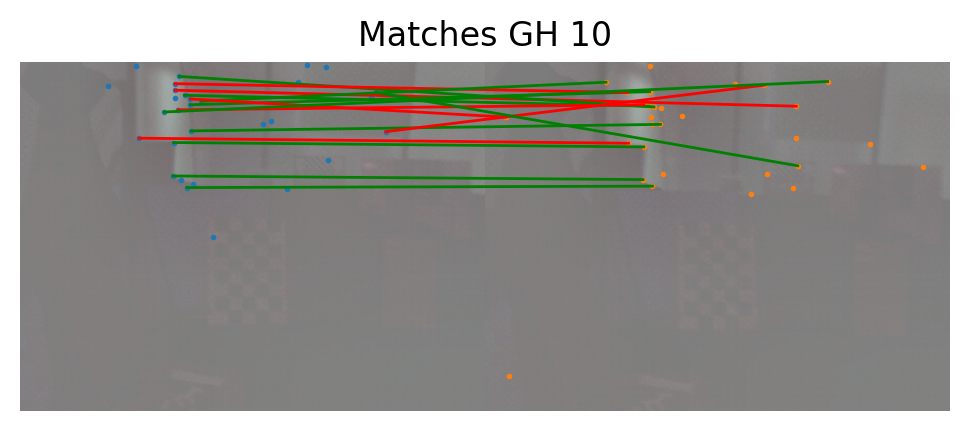

In [8]:
dataset_new_lab = "/home/alena/Documents/dark-slam/datasets/original/2022-03-10-12-54-53/"
dataset_light = "/home/alena/Documents/dark-slam/datasets/original/2021-11-23-22-40-11/"
dataset_semi_dark =  "/home/alena/Documents/dark-slam/datasets/original/2021-24-21-10-35/"
dataset_dark =  "/home/alena/Documents/dark-slam/datasets/original/2021-24-23-27-35/"

dataset = dataset_dark

good_matches_original = []
good_matches_gamma_clahe = []
good_matches_gan = []

num_kp_original = []
num_kp_gamma_clahe = []
num_kp_gan = []

for i in tqdm(range(0, 300)):
    img1 = cv2.imread(dataset + "%06i.png"%i)
    img2 = cv2.imread(dataset + "%06i.png"%(i+1))

    kp1, ds1 = calculate(img1)
    kp2, ds2 = calculate(img2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_original.append(num)
    num_kp_original.append(len(kp1) + len(kp2))
    
    img_gamma1 = model_gamma.predict(img1)
    img_gamma_clahe1 = predict(img_gamma1)
    img_gamma2 = model_gamma.predict(img2)
    img_gamma_clahe2 = predict(img_gamma2)
    
    kp1, ds1 = calculate(img_gamma_clahe1)
    kp2, ds2 = calculate(img_gamma_clahe2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gamma_clahe.append(num)
    num_kp_gamma_clahe.append(len(kp1) + len(kp2))
    # plot_good_matches(img_gamma_clahe1, img_gamma_clahe2, kp1, kp2, ds1, ds2, f"Matches GH {num}")
    # break
    img_gan1 = model_gamma.predict(img1)
    img_gan2 = model_gamma.predict(img2)
    
    kp1, ds1 = calculate(img_gan1)
    kp2, ds2 = calculate(img_gan2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gan.append(num)
    num_kp_gan.append(len(kp1) + len(kp2))
    # plot_good_matches(img_gan1, img_gan2, kp1, kp2, ds1, ds2, f"Matches GAN {num}")
    # break
    
    
    # plot_good_matches(img1, img2, kp1, kp2, ds1, ds2, f"Matches {num}")

#### Number of fatures

(0.0, 20.0)

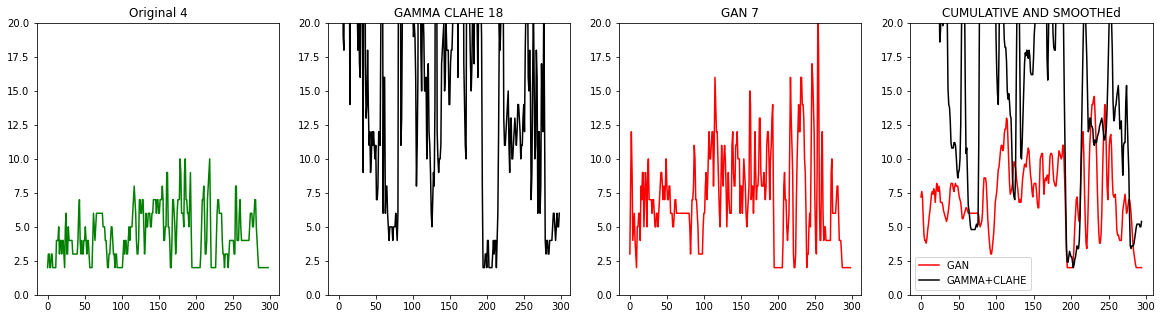

In [48]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=4)
ax[0].plot(num_kp_original[s:e], 'g')
ax[0].set_title(f"Original {round(np.mean(num_kp_original))}")
ax[0].set_ylim(0, 20)

ax[1].plot(num_kp_gamma_clahe[s:e], 'k')
ax[1].set_title(f"GAMMA CLAHE {round(np.mean(num_kp_gamma_clahe))}")
ax[1].set_ylim(0, 20)

ax[2].plot(num_kp_gan[s:e], 'r')
ax[2].set_title(f"GAN {round(np.mean(num_kp_gan))}")
ax[2].set_ylim(0, 20)

N = 5
ax[3].plot(running_mean(num_kp_gan[s:e], N), 'r')
ax[3].plot(running_mean(num_kp_gamma_clahe[s:e], N), 'k')
ax[3].legend([f"GAN ", f"GAMMA+CLAHE"])
ax[3].set_title("CUMULATIVE AND SMOOTHEd")
ax[3].set_ylim(0, 20)

### Number of good matches. Test in Dark

Obviously, in dark conditions Shi-Tomashi + BRIEF works worse than on light images

In [1]:
dataset = dataset_dark

good_matches_original = []
good_matches_gamma_clahe = []
good_matches_gan = []

for i in tqdm(range(0, 300)):
    img1 = cv2.imread(dataset + "%06i.png"%i)
    img2 = cv2.imread(dataset + "%06i.png"%(i+1))

    kp1, ds1 = calculate(img1)
    kp2, ds2 = calculate(img2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_original.append(num)
    
    
    img_gamma1 = model_gamma.predict(img1)
    img_gamma_clahe1 = predict(img_gamma1)
    img_gamma2 = model_gamma.predict(img2)
    img_gamma_clahe2 = predict(img_gamma2)
    
    kp1, ds1 = calculate(img_gamma_clahe1)
    kp2, ds2 = calculate(img_gamma_clahe2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gamma_clahe.append(num)
    plot_good_matches(img_gamma_clahe1, img_gamma_clahe2, kp1, kp2, ds1, ds2, f"Matches GH {num}")
    break
    
    img_gan1 = model_gamma.predict(img1)
    img_gan2 = model_gamma.predict(img2)
    
    kp1, ds1 = calculate(img_gan1)
    kp2, ds2 = calculate(img_gan2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gan.append(num)

s, e = [0, -1]

fig, ax = plt.subplots(figsize=(20, 5), ncols=4)
ax[0].plot(good_matches_original[s:e], 'g')
ax[0].set_title("Original")
ax[0].set_ylim(0, 20)

ax[1].plot(good_matches_gamma_clahe[s:e], 'k')
ax[1].set_title("GAMMA CLAHE")
ax[1].set_ylim(0, 20)

ax[2].plot(good_matches_gan[s:e], 'r')
ax[2].set_title("GAN")
ax[2].set_ylim(0, 20)

N = 5
ax[3].plot(running_mean(good_matches_gan[s:e], N), 'r')
ax[3].plot(running_mean(good_matches_gamma_clahe[s:e], N), 'k')
ax[3].legend([f"GAN {round(sum(running_mean(good_matches_gan[s:e], N)))}", f"GAMMA+CLAHE {round(sum(running_mean(good_matches_gamma_clahe[s:e], N)))}"])
ax[3].set_title("CUMULATIVE AND SMOOTHEd")
ax[3].set_ylim(0, 20)

NameError: name 'dataset_dark' is not defined

### Number of good feaures. Test on light images

100%|██████████| 300/300 [00:21<00:00, 13.81it/s]


(0.0, 20.0)

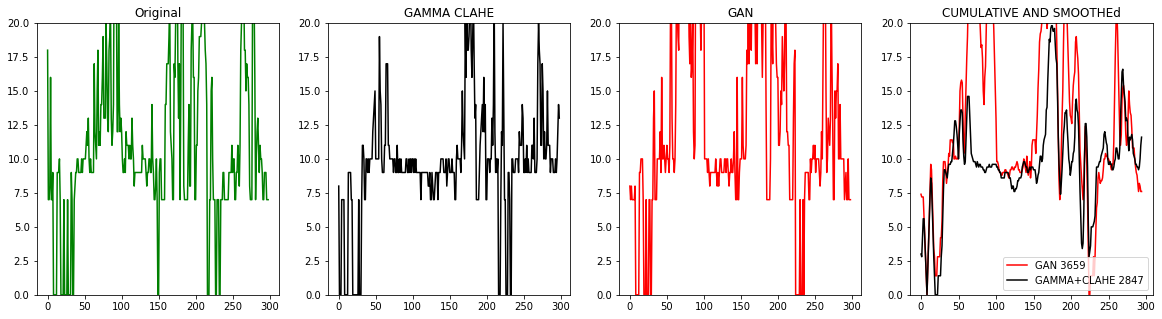

In [31]:
dataset = dataset_new_lab

good_matches_original = []
good_matches_gamma_clahe = []
good_matches_gan = []

for i in tqdm(range(0, 300)):
    img1 = cv2.imread(dataset + "%06i.png"%i)
    img2 = cv2.imread(dataset + "%06i.png"%(i+1))

    kp1, ds1 = calculate(img1)
    kp2, ds2 = calculate(img2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_original.append(num)
    # plot_good_matches(img1, img2, kp1, kp2, ds1, ds2, f"Matches GH {num}")
    
    img_gamma1 = model_gamma.predict(img1)
    img_gamma_clahe1 = predict(img_gamma1)
    img_gamma2 = model_gamma.predict(img2)
    img_gamma_clahe2 = predict(img_gamma2)
    
    kp1, ds1 = calculate(img_gamma_clahe1)
    kp2, ds2 = calculate(img_gamma_clahe2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gamma_clahe.append(num)
    # plot_good_matches(img_gamma_clahe1, img_gamma_clahe2, kp1, kp2, ds1, ds2, f"Matches GH {num}")
    
    img_gan1 = model_gamma.predict(img1)
    img_gan2 = model_gamma.predict(img2)
    
    kp1, ds1 = calculate(img_gan1)
    kp2, ds2 = calculate(img_gan2)
    num, _, _ = find_good_matches(kp1, kp2, ds1, ds2 , i)
    good_matches_gan.append(num)
    # plot_good_matches(img_gan1, img_gan2, kp1, kp2, ds1, ds2, f"Matches GAN {num}")
    
s, e = [0, -1]

fig, ax = plt.subplots(figsize=(20, 5), ncols=4)
ax[0].plot(good_matches_original[s:e], 'g')
ax[0].set_title("Original")
ax[0].set_ylim(0, 20)

ax[1].plot(good_matches_gamma_clahe[s:e], 'k')
ax[1].set_title("GAMMA CLAHE")
ax[1].set_ylim(0, 20)

ax[2].plot(good_matches_gan[s:e], 'r')
ax[2].set_title("GAN")
ax[2].set_ylim(0, 20)

N = 5
ax[3].plot(running_mean(good_matches_gan[s:e], N), 'r')
ax[3].plot(running_mean(good_matches_gamma_clahe[s:e], N), 'k')
ax[3].legend([f"GAN {round(sum(running_mean(good_matches_gan[s:e], N)))}", f"GAMMA+CLAHE {round(sum(running_mean(good_matches_gamma_clahe[s:e], N)))}"])
ax[3].set_title("CUMULATIVE AND SMOOTHEd")
ax[3].set_ylim(0, 20)

Obviously, in dark conditions Tsi-Tomashi + BRIEF works worse than on light images. On bright images, the performance of GAN is even better than on original images. Although, GAN visually degrades visual image quality.

In [36]:
sum(np.array(good_matches_original))

3218

In [37]:
sum(np.array(good_matches_gamma_clahe))

2889

In [39]:
sum(np.array(good_matches_gan))

3698